# Local Frog Discovery Tool 
## SDM Model

A species distribution model is a specific type of machine learning model that aims to predict the distribution of a biological species across geographic space and time. Such models have become increasingly important in conservation efforts globally to better understand and map the habitats of species of interest, particularly threatened or endangered species.

In this model we will be focusig on the distribution of frogs because they are extremely sensitive towards environmental changes, so any changes in their species distribution may indicate an underlying change to biodiversity in the area. The frog species that we will take into consideration is Litoria fallax.
<center>
<img src="pictures/Litoria_fallax.jpg" width="500" height="340">
</center>

<br>

**Aim:** to develop a species distribution model for litoria fallax across Australia using weather data from the TerraClimate dataset.

| Challenge | Locations                     | Spatial Res        | Species          | Satellite Data                                                |
|-----------|-------------------------------|--------------------|------------------|---------------------------------------------------------------|
|***1***    | Australia                     | Coarse (4km)  | 1 species  | TerraClimate                                                  |


As specified in the first row of the table above, we will restrict this model to regions in Australia at coarse resolution (4kmx4km).  We restrict this analysis to a five year window from the start of 2015 to the end of 2019, and will make the assumption that frog occurrences within that time period are representative of the entire time period (i.e. the frogs take longer than 5 years to move).

For this model, we use Azure Virtual Machine to save space.
# Load in dependencies

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
import folium

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
from itertools import cycle
import math

# I. Species Dataset

## I.1. Data preprocessing

In [2]:
# Map country code to country name and continent name
country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }

continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }

# Frog data over the world in 2015 to 2019
df = pd.read_csv('occurrence.txt', sep='\t', parse_dates=['eventDate']).assign(country =  lambda x: x.countryCode.map(country_names),   # create 2 new columns country, continent from countryCode
                continent =  lambda x: x.countryCode.map(continent_names),
                species = lambda x: x.species.str.title())[['gbifID','eventDate','country','continent','stateProvince',                 # choose 8 columns
        'decimalLatitude','decimalLongitude','species']][lambda x: (x.eventDate.dt.year >= 2015) &                                      # choose year from 2015 to 2019
                   (x.eventDate.dt.year <= 2019)]  

### Frog data in Australia from 2015 to 2019

In [3]:
# Frog data in Australia
au_df = df[df['country'] == 'Australia']
au_df

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax
33,1850994254,2017-11-30 08:35:00,Australia,Australia,New South Wales,-33.093048,151.416300,Litoria Fallax
...,...,...,...,...,...,...,...,...
193707,2420099493,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.734715,144.328494,Crinia Signifera
193715,2420099296,2016-04-25 00:00:00,Australia,Australia,Victoria,-37.861180,144.268865,Crinia Signifera
193719,2420099324,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.845236,144.354168,Crinia Signifera
193720,2420099687,2016-05-15 00:00:00,Australia,Australia,Victoria,-38.176213,144.355254,Crinia Signifera


In [4]:
all_au_df = au_df.copy()

### Plot frog data in Australia

In [5]:
def plot_species(fig, ax, frog_data, name, cmap_params={'alpha':0.5}, scatter_params={'alpha':0.5}):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=color['color'],
            **scatter_params
        )

    # Add other features
    ax[0].set_title(f"Frog occurrences for {name}")
    ax[1].set_title(f"Frog species distribution in {name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, **cmap_params) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()

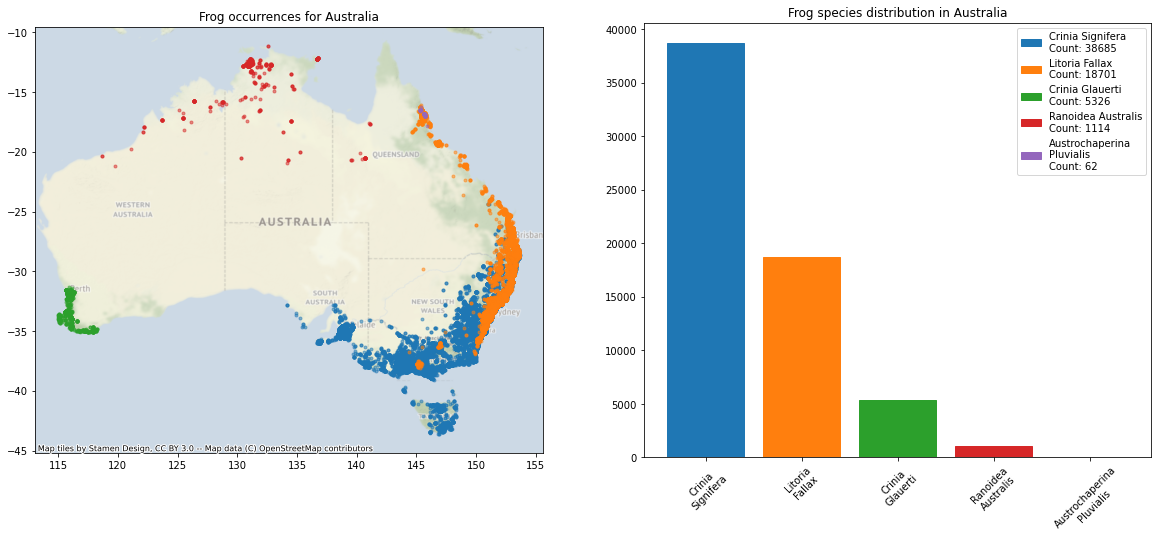

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
plot_species(fig, ax, au_df, 'Australia')

## I.2. Litoria Fallax species in Australia from 2015 to 2019

### Find the boundary box

In [7]:
# Litoria Fallax data in Australia
lf_df = au_df[au_df['species'] == 'Litoria Fallax']
lf_df

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax
33,1850994254,2017-11-30 08:35:00,Australia,Australia,New South Wales,-33.093048,151.416300,Litoria Fallax
...,...,...,...,...,...,...,...,...
193484,1457334961,2017-01-23 00:00:00,Australia,Australia,New South Wales,-34.924979,150.647032,Litoria Fallax
193486,3108865868,2019-02-03 00:00:00,Australia,Australia,New South Wales,-34.028797,151.225626,Litoria Fallax
193507,3408189344,2019-12-24 21:22:00,Australia,Australia,Queensland,-26.754987,152.839291,Litoria Fallax
193510,2981077059,2018-11-22 03:59:00,Australia,Australia,New South Wales,-34.791600,150.779300,Litoria Fallax


In [8]:
min_lat = lf_df['decimalLatitude'].min()
max_lat = lf_df['decimalLatitude'].max()
min_lon = lf_df['decimalLongitude'].min()
max_lon = lf_df['decimalLongitude'].max()

bbox = (min_lon, min_lat, max_lon, max_lat)
print(bbox)

(144.35052, -38.12691, 153.614, -16.048582)


### Plot Litoria Fallax species in Australia from 2015 to 2019

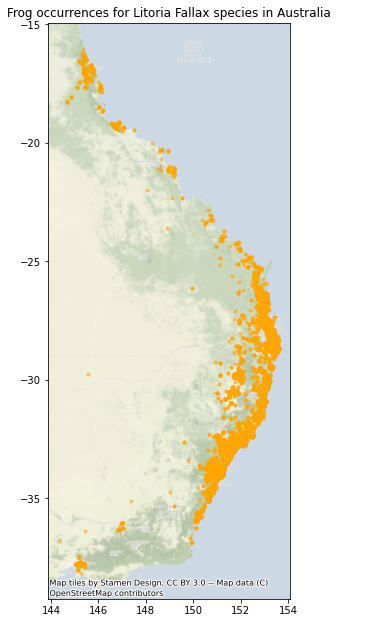

In [9]:
fig = plt.figure(figsize=(20, 8))
ax  = fig.add_axes([0,0,1,1])

# Scatter plot
ax.scatter(lf_df.decimalLongitude, 
           lf_df.decimalLatitude, 
           marker='.',
           color = 'orange',
           **{'alpha':0.5})

# Add other features
ax.set_title(f"Frog occurrences for Litoria Fallax species in Australia")
cx.add_basemap(ax, crs={'init':'epsg:4326'}, **{'alpha':0.5}) # Add basemap

## I.3. Pseudo-absence

The plot above shows how frog occurrences are heavily biased around urban areas, where people are more likely to come across them. They also cluster tightly around towns, parks, bush trails etc. This is one issue that would be worth addressing to maximise success.

One method of addressing the sampling bias inherent in the database is to use the occurrence points of other species as absence points for the target species. This is called pseudo-absence and is a common technique in species distribution modelling. This way, if a different species of frog has been sighted in a specific location, we can be more certain that the species we are trying to predict is not at that same location. Alternatively, if we just picked a random point where there are no frog occurrences, we cannot be certain that frogs are not in that location. It might just be that there are no walking tracks near that location, and therefore the frogs would not show up in our database.

For this notebook, we will use the other species as examples of litoria fallax's absence. We will alter our response variable to be `occurenceStatus` which will take the value of 1 if the occurrence species is litoria fallax, and 0 if the species is not litoria fallax.

In [10]:
# Create occurenceStatus column for frog data in Australia within the boundary box
au_df = au_df[lambda x: 
        (x.decimalLongitude >= min_lon) &
        (x.decimalLatitude >= min_lat) &
        (x.decimalLongitude <= max_lon) &
        (x.decimalLatitude <= max_lat)]

au_df = au_df.assign(occurrenceStatus = lambda x: np.where(x.species == 'Litoria Fallax', 1, 0))
au_df

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax,1
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax,1
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax,1
23,2563750401,2017-10-25 21:07:00,Australia,Australia,New South Wales,-32.968624,151.644194,Litoria Fallax,1
33,1850994254,2017-11-30 08:35:00,Australia,Australia,New South Wales,-33.093048,151.416300,Litoria Fallax,1
...,...,...,...,...,...,...,...,...,...
193507,3408189344,2019-12-24 21:22:00,Australia,Australia,Queensland,-26.754987,152.839291,Litoria Fallax,1
193510,2981077059,2018-11-22 03:59:00,Australia,Australia,New South Wales,-34.791600,150.779300,Litoria Fallax,1
193515,2573827842,2019-04-22 18:11:00,Australia,Australia,Queensland,-27.497691,153.018211,Litoria Fallax,1
193719,2420099324,2016-09-17 00:00:00,Australia,Australia,Victoria,-37.845236,144.354168,Crinia Signifera,0


### Plot frog data in Australia within the boundary box

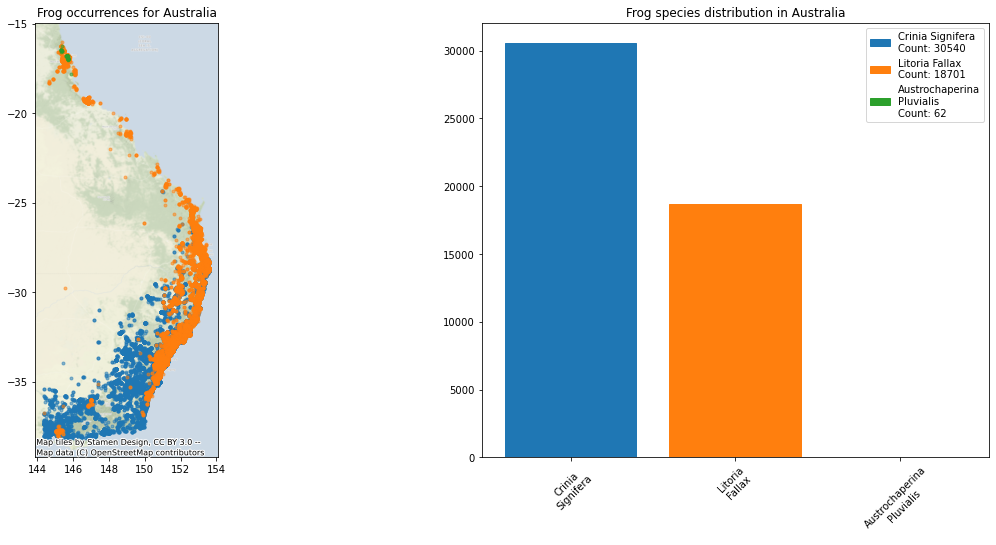

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
plot_species(fig, ax, au_df, 'Australia')

# II. TerraClimate Dataset

## II.1. Define the analysis region and view on a map

First, we define our area of interest using latitude and longitude coordinates

In [12]:
def _degree_to_zoom_level(l1, l2, margin = 0.0):
    
    degree = abs(l1 - l2) * (1 + margin)
    zoom_level_int = 0
    if degree != 0:
        zoom_level_float = math.log(360/degree)/math.log(2)
        zoom_level_int = int(zoom_level_float)
    else:
        zoom_level_int = 18
    return zoom_level_int

def display_map(latitude = None, longitude = None):
    margin = -0.5
    zoom_bias = 0
    lat_zoom_level = _degree_to_zoom_level(margin = margin, *latitude ) + zoom_bias
    lon_zoom_level = _degree_to_zoom_level(margin = margin, *longitude) + zoom_bias
    zoom_level = min(lat_zoom_level, lon_zoom_level) 
    center = [np.mean(latitude), np.mean(longitude)]
    
    map_hybrid = folium.Map(location=center,zoom_start=zoom_level, 
        tiles=" http://mt1.google.com/vt/lyrs=y&z={z}&x={x}&y={y}",attr="Google")
    
    line_segments = [(latitude[0],longitude[0]),(latitude[0],longitude[1]),
                     (latitude[1],longitude[1]),(latitude[1],longitude[0]),
                     (latitude[0],longitude[0])]
    
    map_hybrid.add_child(folium.features.PolyLine(locations=line_segments,color='red',opacity=0.8))
    map_hybrid.add_child(folium.features.LatLngPopup())        

    return map_hybrid

In [13]:
# Plot bounding box on a map
bbox = (min_lon, min_lat, max_lon, max_lat)
latitude = (min_lat, max_lat)
longitude = (min_lon, max_lon)

f = folium.Figure(width=600, height=600)
m = display_map(latitude,longitude)
f.add_child(m)

## II.2. Accessing the TerraClimate Data

To get the TerraClimate data, we fetch all data intersecting with the bounding box and will calculate various metrics over the time dimension for each coordinate. 

To assist in visualisations, we use interpolation functionality which will allow the comparitively coarse temporal resolution of the terraclimate data to be mapped to a larger set of coordinates, creating an ($n$ x $m$) image. We will choose (512 x 1024)

In [14]:
# Load the data for analysis
collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")     
asset = collection.assets["zarr-https"]
store = fsspec.get_mapper(asset.href)
data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])

In [15]:
weather_data = data.sel(lon=slice(min_lon,max_lon),             # Select datapoints that overlap the boundary box of Litoria Fallax species
                    lat=slice(max_lat,min_lat),
                    time=slice('2015-01-01','2019-12-31'))[['aet','def','pdsi','pet','ppt','q','soil','srad','swe','tmax','tmin','vap','vpd','ws']].rename(lat='y', lon='x').to_array().compute()

In [16]:
# Calculate 3 metrics for 14 chosen columns
combined_values = []
combined_bands = []

metrics = {'mean':{'fn':np.nanmean,'params':{}},
            'min':{'fn':np.nanmin,'params':{}},
            'max':{'fn':np.nanmax, 'params':{}}}

for name, metric in metrics.items():
    sum_data = xr.apply_ufunc(metric['fn'], weather_data, input_core_dims=[["time"]], kwargs=metric['params'], 
                              dask = 'allowed', vectorize = True).rename(variable='band')
    xcoords = sum_data.x
    ycoords = sum_data.y
    dims = sum_data.dims
    combined_values.append(sum_data.values)
    for band in sum_data.band.values:
        combined_bands.append(band+'_'+name)

# Combine metrics
combined_values = np.concatenate(combined_values, axis=0)
weather_data = xr.DataArray(data=combined_values,
                             dims=dims,
                             coords=dict(band=combined_bands,
                                         y=ycoords,
                                         x=xcoords))    

# Take relevant bands:
weather_data = weather_data.sel(band=['aet_mean','def_mean','pdsi_mean','pet_mean','ppt_mean','q_mean','soil_mean',
                         'srad_mean','swe_mean','tmax_mean','tmin_mean','vap_mean','vpd_mean','ws_mean'])

In [17]:
# Interpolate values to a 512x1024 image
interp_dims = (512, 1024)
interp_coords = (np.linspace(min_lon, max_lon, interp_dims[0]), 
                 np.linspace(min_lat, max_lat, interp_dims[1]))

weather_data = weather_data.interp(x=interp_coords[0], y=interp_coords[1],
                                   method='nearest', kwargs={"fill_value": "extrapolate"})

In [18]:
print(weather_data)

<xarray.DataArray (band: 14, y: 1024, x: 512)>
array([[[36.4       , 36.4       , 35.23333333, ...,         nan,
                 nan,         nan],
        [36.4       , 36.4       , 35.23333333, ...,         nan,
                 nan,         nan],
        [36.4       , 36.4       , 35.23333333, ...,         nan,
                 nan,         nan],
        ...,
        [65.45      , 65.45      , 65.25      , ...,         nan,
                 nan,         nan],
        [65.36666667, 65.36666667, 65.71666667, ...,         nan,
                 nan,         nan],
        [65.36666667, 65.36666667, 65.71666667, ...,         nan,
                 nan,         nan]],

       [[76.75      , 76.75      , 78.13333333, ...,         nan,
                 nan,         nan],
        [76.75      , 76.75      , 78.13333333, ...,         nan,
                 nan,         nan],
        [76.75      , 76.75      , 78.13333333, ...,         nan,
                 nan,         nan],
...
        [ 1.5619

## II.3. Visualising the TerraClimate Data

The frequency distribution of each variable is displayed below. There is some skewness present in a few variables, so you might want to address this when training your own model. Depending on the type of model you decide to train, some of the variables might require normalisation, standardisation, or transformation. For now, we will proceed with the variables as they come.

Text(0.5, 0.98, 'Frequency distribution of TerraClimate variables')

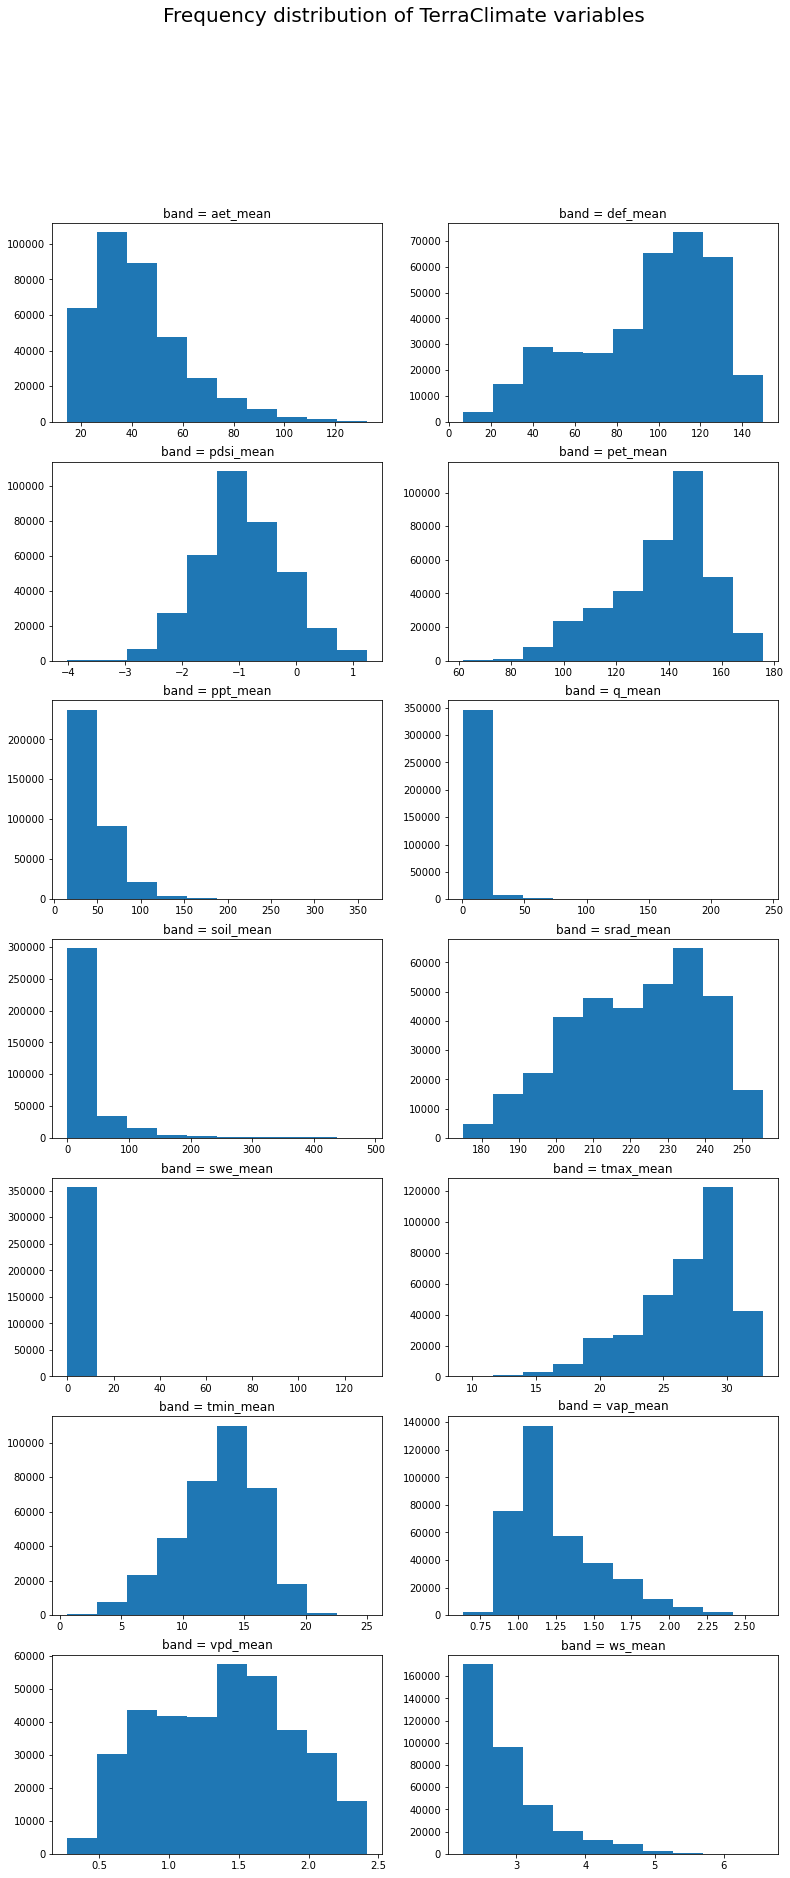

In [19]:
fig, ax = plt.subplots(7, 2, figsize=(13, 30))

bands = weather_data.band.values
for i in range(len(bands)):
    xr.plot.hist(weather_data[i], ax=ax[i//2, i%2])

fig.suptitle("Frequency distribution of TerraClimate variables",  fontsize=20)

# III. Joining weather data to the species data

Now that we have read in our predictor variables, we need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

In [20]:
au_df['key'] = au_df.index

In [21]:
weather_data = weather_data.rename('data').sel(x=xr.DataArray(au_df.decimalLongitude, dims="key", coords={"key": au_df.index}), 
                    y=xr.DataArray(au_df.decimalLatitude, dims="key", coords={"key": au_df.index}),
                    method="nearest").to_dataframe().assign(val = lambda x: x.iloc[:, -1])[['val']].reset_index().drop_duplicates().pivot(index="key", columns="band", values="val").reset_index()

In [22]:
model_data = au_df.merge(weather_data, on = "key", how = 'inner')
model_data.drop(['key','gbifID','country', 'continent','stateProvince','species'], axis = 1, inplace = True)
model_data.head()

,eventDate,decimalLatitude,decimalLongitude,occurrenceStatus,aet_mean,def_mean,pdsi_mean,pet_mean,ppt_mean,q_mean,soil_mean,srad_mean,swe_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean
0,2018-04-18 19:05:00,-33.693144,151.320884,1,83.600000,34.233333,-1.655000,117.783333,97.766667,14.366667,75.566667,196.116667,0.0,23.578335,13.778335,1.451000,0.716833,4.141667
1,2019-08-28 09:24:00,-33.925746,151.164082,1,79.783333,40.133333,-1.598333,119.933333,89.583333,9.933333,80.833333,191.533333,0.0,23.538335,14.068335,1.435667,0.755167,4.315000
2,2018-02-13 23:02:00,-31.732415,152.088515,1,82.150000,30.433333,-2.233333,112.600000,91.600000,10.333333,95.583333,201.816667,0.0,23.356668,10.981668,1.253167,0.769500,2.875000
3,2017-10-25 21:07:00,-32.968624,151.644194,1,75.250000,45.200000,-2.108333,120.466667,84.133333,8.866667,73.650000,199.816667,0.0,23.895002,13.938335,1.473000,0.737833,4.123333
4,2017-11-30 08:35:00,-33.093048,151.416300,1,72.933333,42.833333,-2.015000,115.683333,81.216667,8.550000,61.833333,198.766667,0.0,23.756668,13.061669,1.433333,0.724333,3.653333


In [23]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49303 entries, 0 to 49302
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   eventDate         49303 non-null  datetime64[ns]
 1   decimalLatitude   49303 non-null  float64       
 2   decimalLongitude  49303 non-null  float64       
 3   occurrenceStatus  49303 non-null  int64         
 4   aet_mean          49258 non-null  float64       
 5   def_mean          49258 non-null  float64       
 6   pdsi_mean         49258 non-null  float64       
 7   pet_mean          49258 non-null  float64       
 8   ppt_mean          49258 non-null  float64       
 9   q_mean            49258 non-null  float64       
 10  soil_mean         49258 non-null  float64       
 11  srad_mean         49258 non-null  float64       
 12  swe_mean          49258 non-null  float64       
 13  tmax_mean         49258 non-null  float64       
 14  tmin_mean         4925

## III.1. Drop null

In [24]:
def features_with_missing_values(data):
    x = data.isnull().sum().sum()/(data.shape[0]*data.shape[1])*100
    print('Percentage of Total Missing Values is' ,round(x,2) ,'%')
    print('Missing Value Estimation:')
    for i in data.columns:
        if data[i].isna().sum()>0:
            print('    The Feature',i,'has '+ str(data[i].isna().sum()) + ' missing values')
            
features_with_missing_values(model_data)

Percentage of Total Missing Values is 0.07 %
Missing Value Estimation:
    The Feature aet_mean has 45 missing values
    The Feature def_mean has 45 missing values
    The Feature pdsi_mean has 45 missing values
    The Feature pet_mean has 45 missing values
    The Feature ppt_mean has 45 missing values
    The Feature q_mean has 45 missing values
    The Feature soil_mean has 45 missing values
    The Feature srad_mean has 45 missing values
    The Feature swe_mean has 45 missing values
    The Feature tmax_mean has 45 missing values
    The Feature tmin_mean has 45 missing values
    The Feature vap_mean has 45 missing values
    The Feature vpd_mean has 45 missing values
    The Feature ws_mean has 45 missing values


Null Value constitues around only 0.07% of dataset. Hence, it is good to drop these rows without much loss of information and maintain the robustness for model

In [25]:
model_data.dropna(inplace= True)

## III.2. Data Visualization

### Kernel Density Plot

In [26]:
import seaborn as sns

In [27]:
predictors = model_data.columns[4:]
predictors

Index(['aet_mean', 'def_mean', 'pdsi_mean', 'pet_mean', 'ppt_mean', 'q_mean',
       'soil_mean', 'srad_mean', 'swe_mean', 'tmax_mean', 'tmin_mean',
       'vap_mean', 'vpd_mean', 'ws_mean'],
      dtype='object')

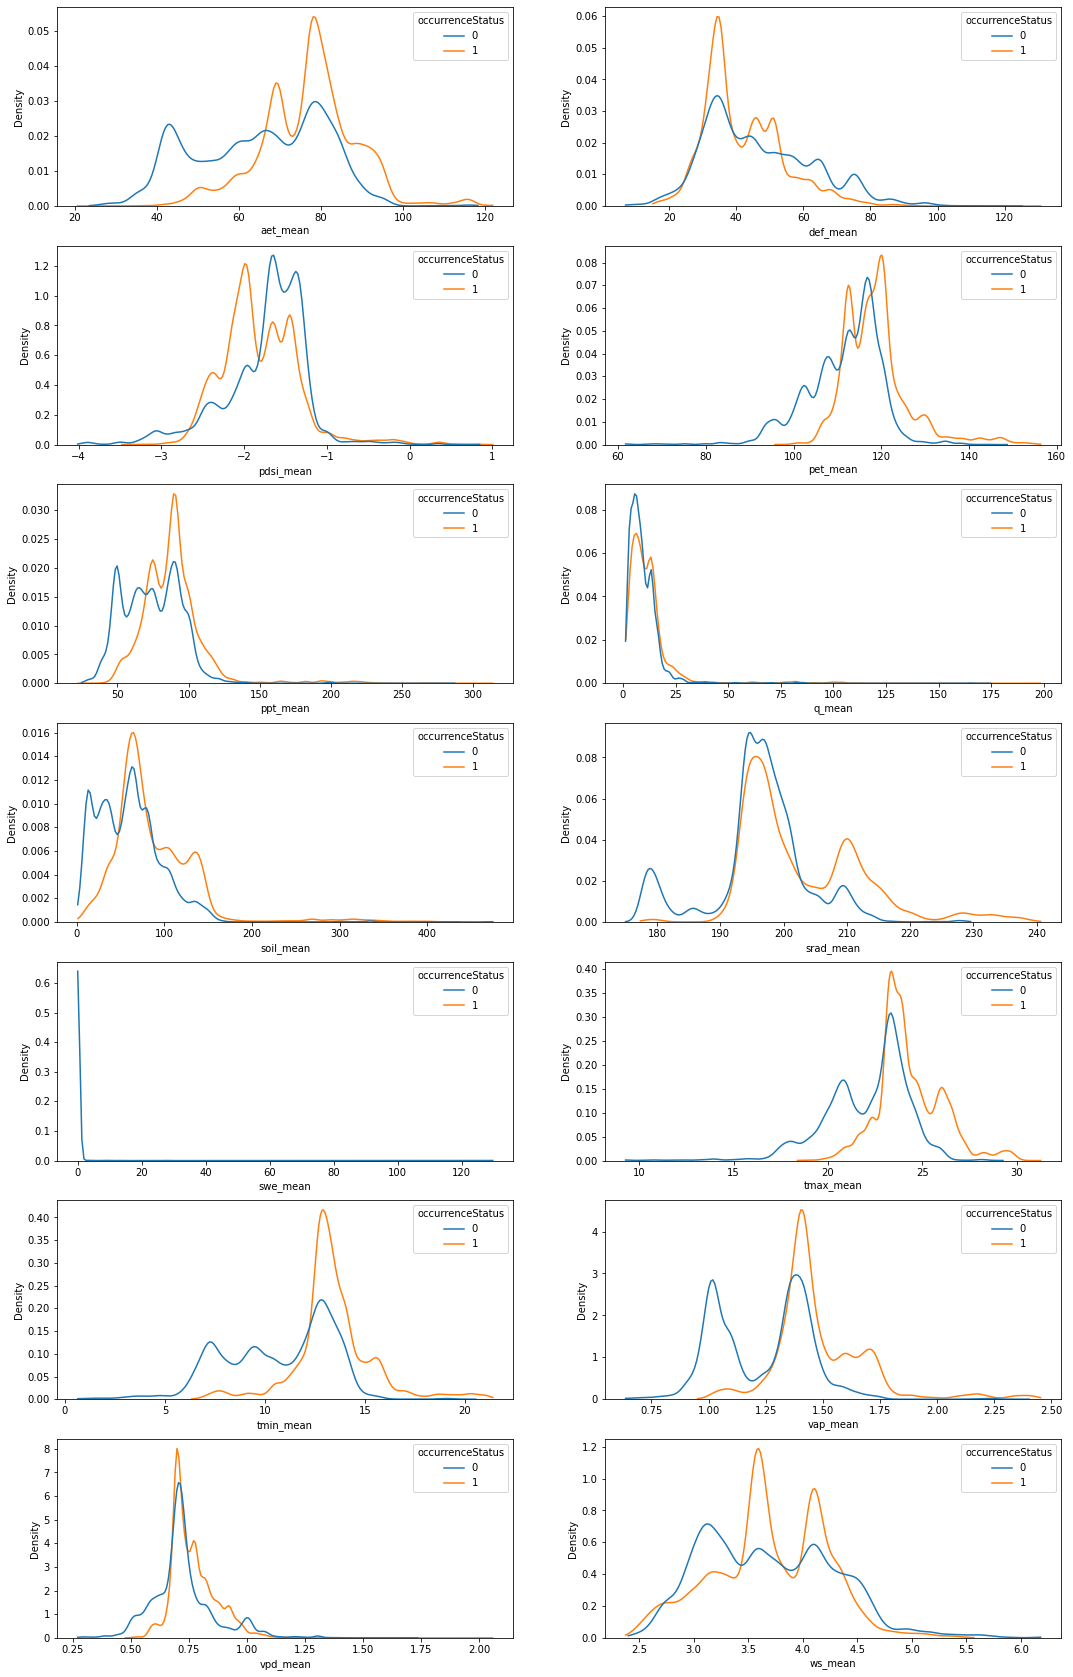

In [28]:
fig, axes = plt.subplots(7, 2, figsize=(18, 30))
for i in range(len(predictors)):
    sns.kdeplot(ax = axes[i//2, i%2], data=model_data, x=predictors[i], hue="occurrenceStatus", cut=0, common_norm=False, alpha=1)
plt.show() 

From the kernel density plot, we can deduce that Litoria Fallax has narrower tolerance living range compared to other species. This species is also sensitive to environmental conditions. A small change can leads to huge increase or decrease of their population

### Correlation matrix

In [29]:
cor_matrix=model_data[['aet_mean',
 'def_mean',
 'pdsi_mean',
 'pet_mean',
 'ppt_mean',
 'q_mean',
 'soil_mean',
 'srad_mean',
 'swe_mean',
 'tmax_mean',
 'tmin_mean',
 'vap_mean',
 'vpd_mean',
 'ws_mean','occurrenceStatus']].corr().round(decimals=1)
cor_matrix

,aet_mean,def_mean,pdsi_mean,pet_mean,ppt_mean,q_mean,soil_mean,srad_mean,swe_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean,occurrenceStatus
aet_mean,1.0,-0.8,-0.1,0.3,0.9,0.6,0.8,0.3,-0.0,0.5,0.7,0.8,-0.2,0.3,0.4
def_mean,-0.8,1.0,0.1,0.3,-0.8,-0.5,-0.7,0.1,-0.1,0.1,-0.3,-0.3,0.7,-0.3,-0.2
pdsi_mean,-0.1,0.1,1.0,-0.0,0.0,0.3,-0.0,0.2,0.1,-0.1,-0.2,-0.1,0.0,-0.2,-0.1
pet_mean,0.3,0.3,-0.0,1.0,0.3,0.1,0.3,0.7,-0.2,0.9,0.8,0.8,0.7,0.1,0.4
ppt_mean,0.9,-0.8,0.0,0.3,1.0,0.8,0.9,0.3,0.1,0.4,0.6,0.7,-0.2,0.4,0.3
q_mean,0.6,-0.5,0.3,0.1,0.8,1.0,0.7,0.3,0.3,0.1,0.3,0.4,-0.2,0.3,0.1
soil_mean,0.8,-0.7,-0.0,0.3,0.9,0.7,1.0,0.3,0.0,0.4,0.6,0.7,-0.1,0.3,0.3
srad_mean,0.3,0.1,0.2,0.7,0.3,0.3,0.3,1.0,-0.1,0.7,0.5,0.6,0.5,-0.3,0.4
swe_mean,-0.0,-0.1,0.1,-0.2,0.1,0.3,0.0,-0.1,1.0,-0.3,-0.2,-0.1,-0.2,0.2,-0.0
tmax_mean,0.5,0.1,-0.1,0.9,0.4,0.1,0.4,0.7,-0.3,1.0,0.9,0.9,0.7,-0.1,0.5


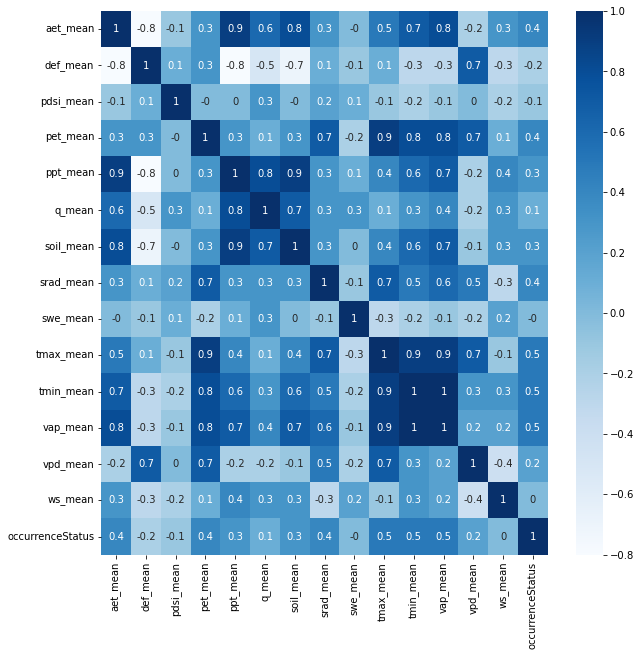

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(cor_matrix, annot = True, cmap='Blues', ax = ax)
plt.show()

As can be seen from the correlation matrix, there are some predictors that are correlated to each other:

    1. pet_mean, tmax_mean, tmin_mean, vap_mean
    2. ppt_mean, soil_mean, aet_mean
 
This may cause multicollinarity problem leading to inaccurate parameter when we train the models. Hence, some unnecessary columns need dropping. In our case, we drop `vap_mean` becasue the value is 1 when it comes to the correlation with tmin_mean

Also, precipitation is also considered to be dropped as common sense, we can know that soil moisture and evaporation index are highly proprtional to rain index, so the two factors are good enough for our model. Hence, we remove `ppt_mean`

### Pairplot

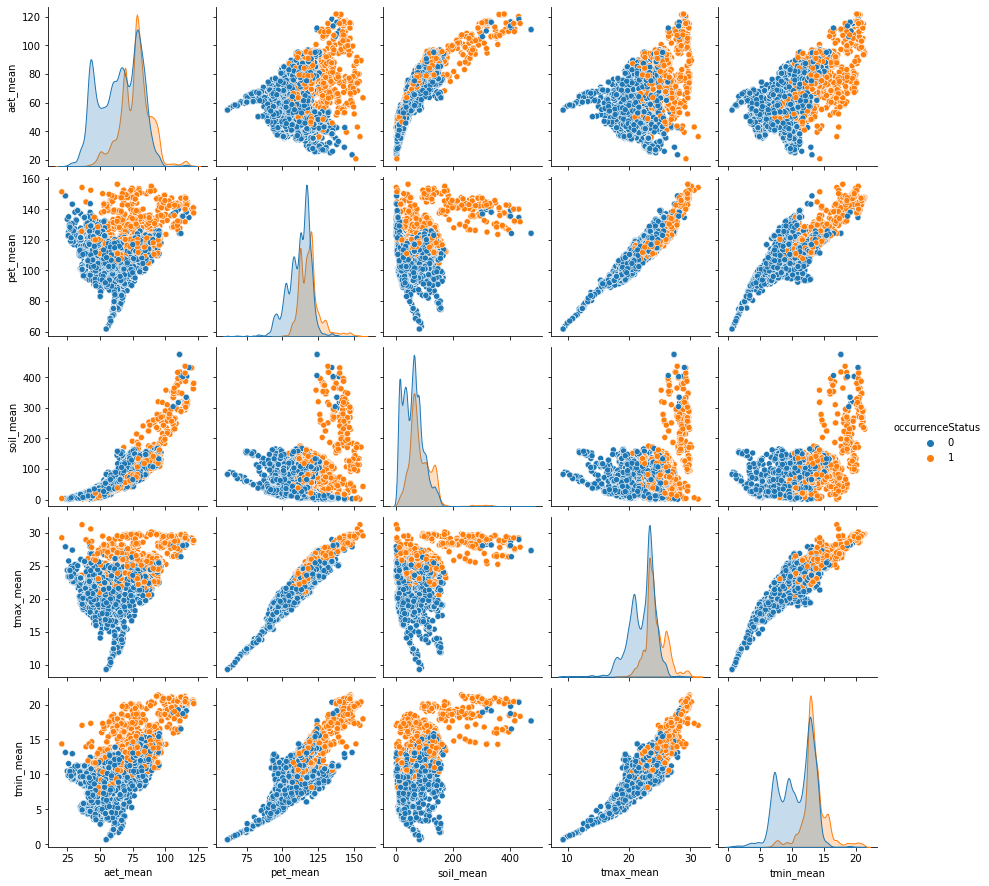

In [31]:
sns.pairplot(model_data[['aet_mean',
 'pet_mean',
 'soil_mean',
 'tmax_mean',
 'tmin_mean', 'occurrenceStatus']], hue = 'occurrenceStatus')

There is a clear separation between our target frog and other species

### Box plot

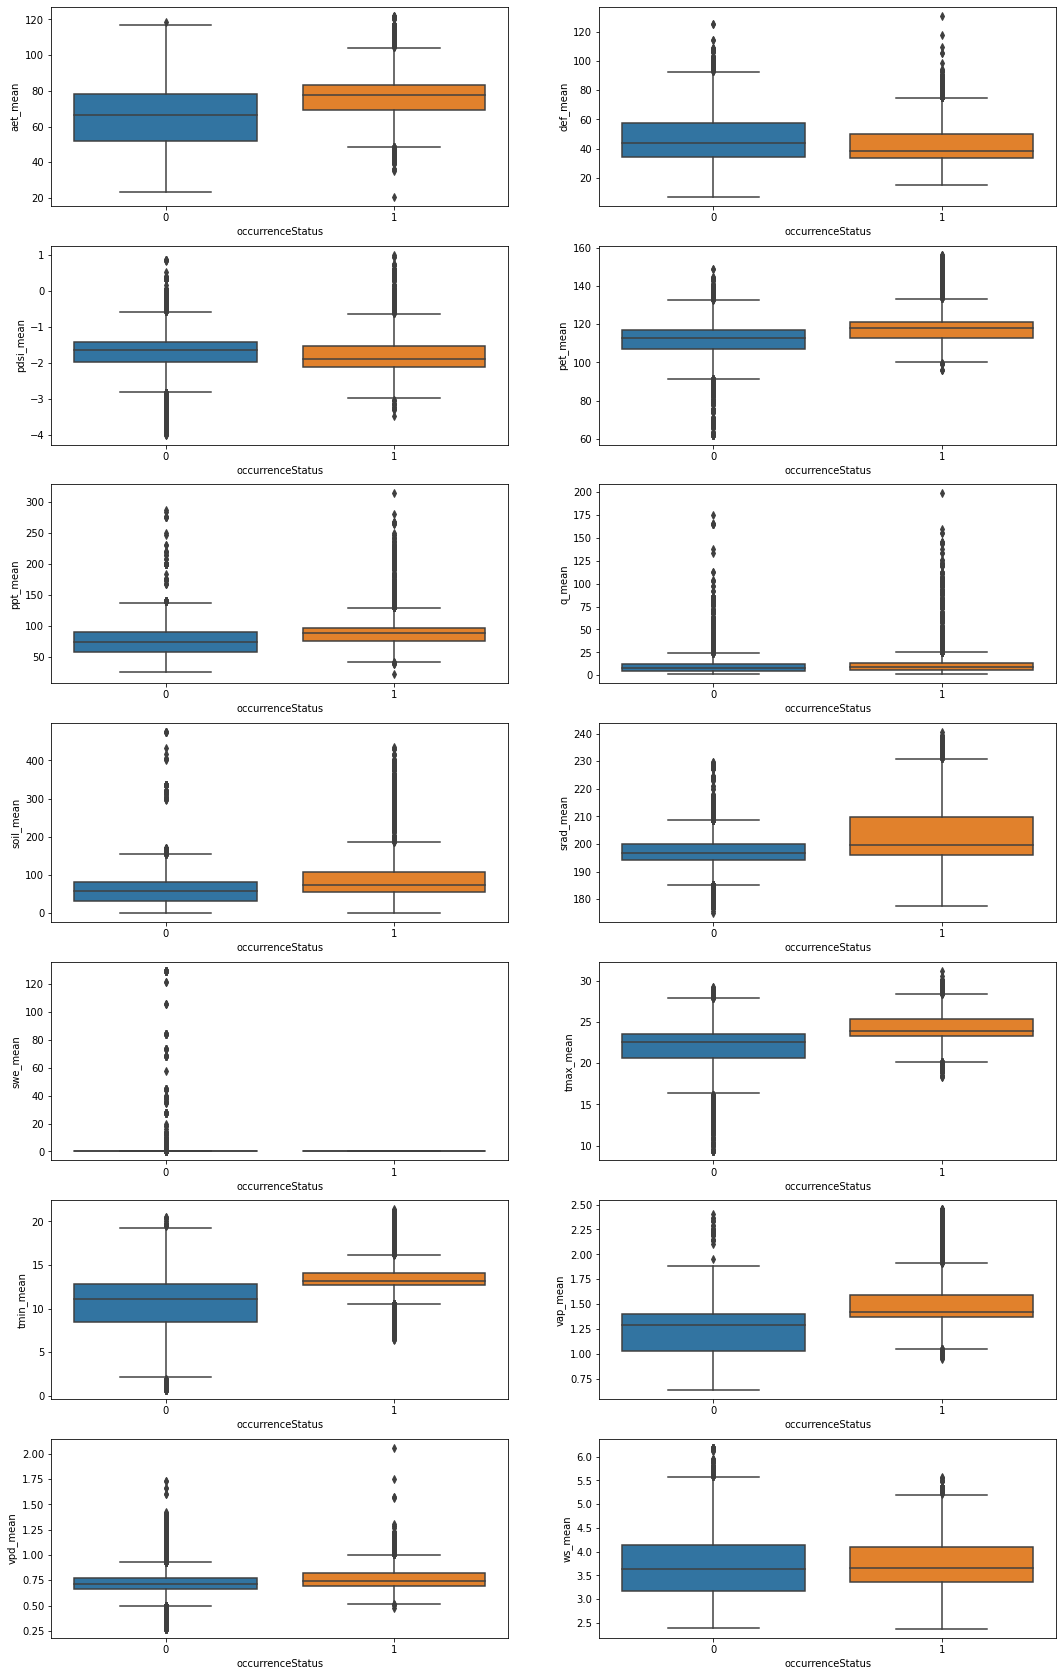

In [32]:
fig, axes = plt.subplots(7, 2, figsize=(18, 30))
 
for i in range(len(predictors)):
    sns.boxplot(ax = axes[i//2, i%2], data=model_data, y=predictors[i], x="occurrenceStatus")
plt.show() 

Though there are some outliers in the data, we won't drop them due to:

    1. Loss of important information
    2. Our models we intend to use like XGBoost, Random Forest, and Neural Network, which are robust to outliers
    3. Because there are visibily difference in outliers between two species, it would play an important part for our model that requiring rules to train
    
The only thing here is that we need to drop `swe_mean` as there are almost 0 in this column

### Time-series visualization

In [33]:
data1 = data.sel(lon=slice(min_lon,max_lon),             # Select datapoints that overlap the boundary box of Litoria Fallax species
                    lat=slice(max_lat,min_lat),
                    time=slice('2015-01-01','2019-12-31'))[['aet','def','pdsi','pet','q','soil','srad','swe','tmax','tmin','vpd','ws']]

In [34]:
predictors1 = ['aet','def','pdsi','pet','q','soil','srad','swe','tmax','tmin','vpd','ws']

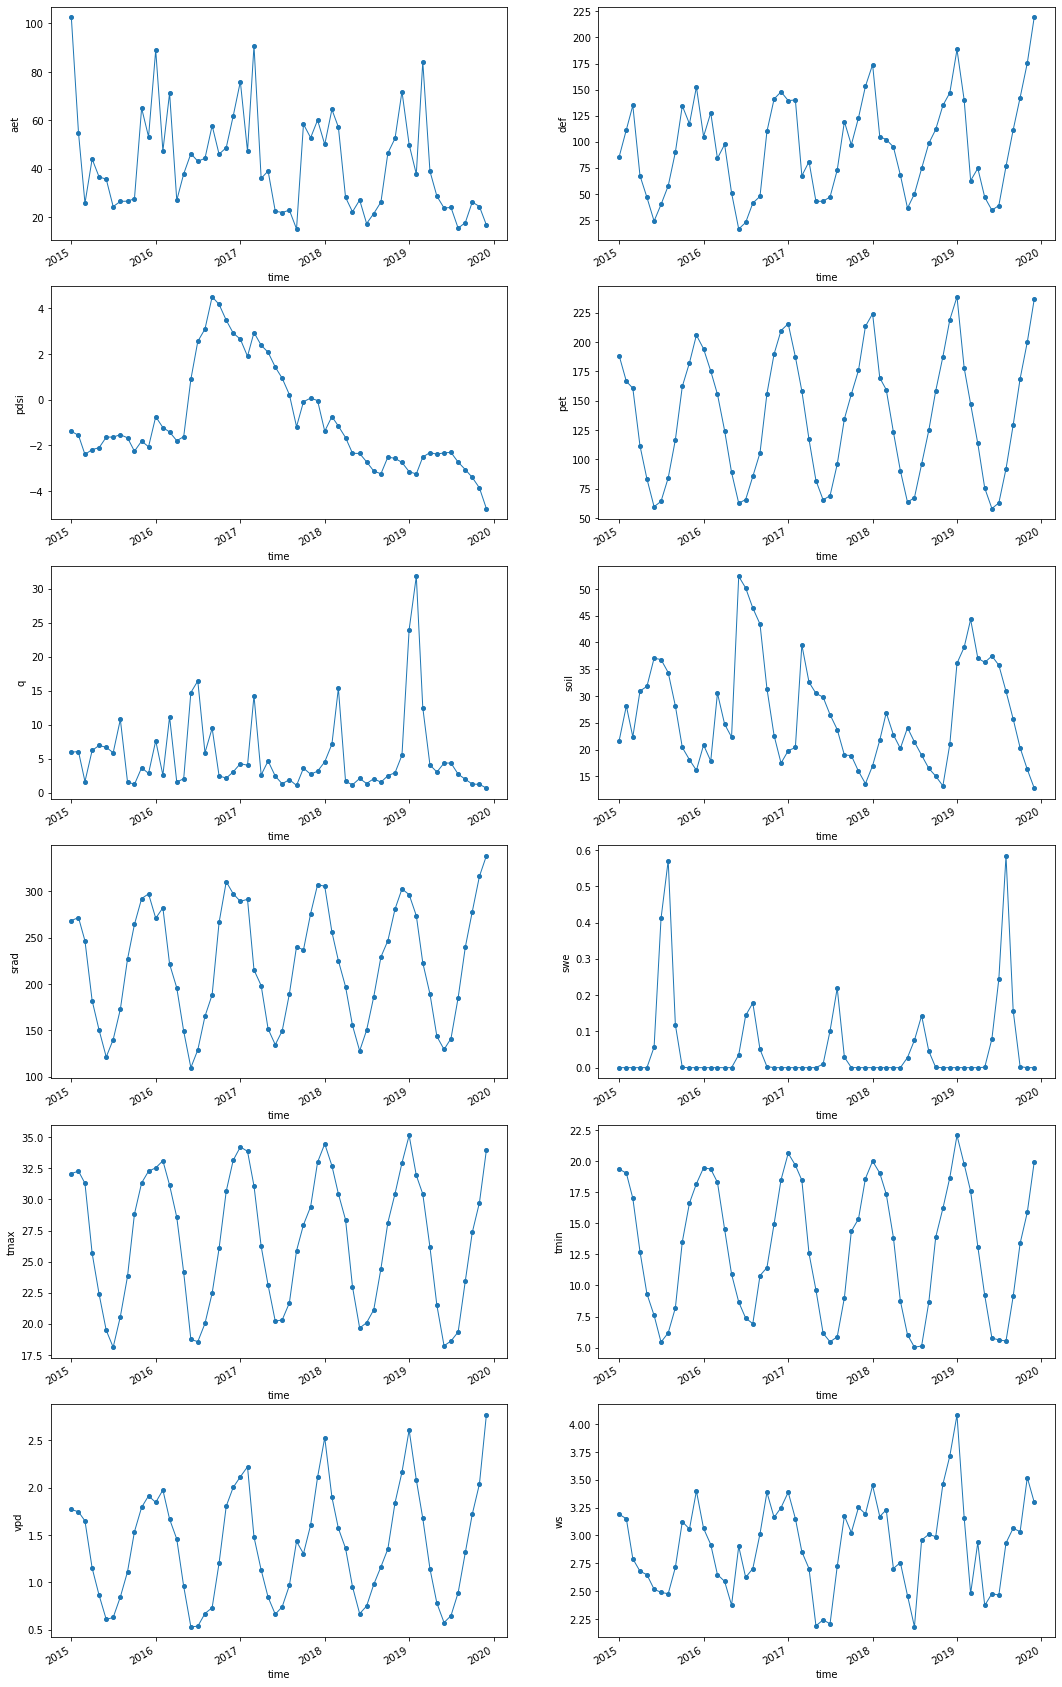

In [35]:
fig, axes = plt.subplots(6, 2, figsize=(18, 30))

for i in range(len(predictors1)):
    data1[predictors1[i]].mean(dim=["lat","lon"]).plot(marker='o',markersize=4,linewidth=1, ax = axes[i//2, i%2])

fig.show()

The line chart shows the periodic change from years to years, so ***mean metric*** calculated earlier is useful for predicting our species

# IV. Machine Learning algorithm

Our dataset is ***quite imbalanced*** with 60% of 0 and 40% of 1. So we decided to use **StratifiedKFold** and **F1 score** is our model evaluation

## IV.1. Model evaluation using StratifiedKFold

To avoid overfitting, we use 5 folds cross validation to estimate F1 score. This will split the dataset into 5 parts, in which 4 parts for training and the remaining one for testing.

In [36]:
X = model_data.drop(['eventDate','occurrenceStatus','decimalLatitude','decimalLongitude','ppt_mean','swe_mean','vap_mean'], axis = 1).reset_index(drop=True)
y = model_data['occurrenceStatus'].reset_index(drop=True)

In [37]:
def model_evaluation(models, X, y):
    names = []
    f1_mean = []
    
    for name, model in models:
        names.append(name)
        f1 = []

        skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            # Split the dataset
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            if (name == 'GLM'):
                model_data.exog = np.array(X_train)
                model_data.endog = np.array(y_train)
                glm = sm.GLM(model_data.endog, model_data.exog, family=sm.families.Binomial())
                glm_ = glm.fit()
                y_pred = glm_.predict(X_test)
                y_pred = np.where(y_pred >= 0.5, 1, 0)
                f1.append(f1_score(y_test, y_pred))
                
                break

            # Fit the model with the training set
            model.fit(X_train, y_train)
            
            # Calculate F1 score
            y_pred = model.predict(X_test)
            f1.append(f1_score(y_test, y_pred))
                
        f1_mean.append(np.mean(f1).round(7))
    
    return names, f1_mean

In [38]:
# Import all the functions and objects we want to test
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from pyearth import Earth
from pygam import LogisticGAM
import statsmodels.api as sm

In [40]:
models = []
# Decision Tree Classifier
models.append(('CART', DecisionTreeClassifier()))

#XGBoost
models.append(('XGB', XGBClassifier()))

# Random Forest Classifier
models.append(('RFC', RandomForestClassifier()))

#MARS - Multivariate Adaptive Regression Splines
models.append(('MARS', Pipeline([("earth", Earth()),("logistic", LogisticRegression())])))

#GAM - Generalized Additive Model
models.append(('GAM', LogisticGAM()))

#GLM - Generalized Linear Model
models.append(('GLM', sm.GLM))

In [41]:
names, f1_mean = model_evaluation(models, X, y)
list_of_tuples = list(zip(names, f1_mean))

summary = pd.DataFrame(list_of_tuples, columns = ['Name','F1 score']) 
summary

[21:24:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:24:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:25:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:25:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,Name,F1 score
0,CART,0.756804
1,XGB,0.758695
2,RFC,0.760168
3,MARS,0.548051
4,GAM,0.702837
5,GLM,0.624276


## IV.2. ROC Curve

In [42]:
from sklearn.model_selection import StratifiedShuffleSplit

skf = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

[21:28:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

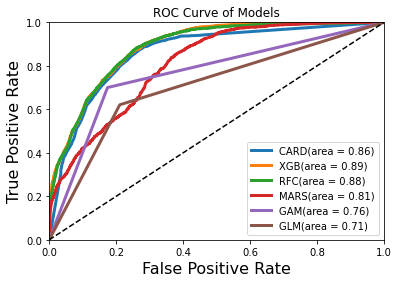

<Figure size 720x432 with 0 Axes>

In [43]:
# Decision Tree Classifier
cart = DecisionTreeClassifier()
cart.fit(X_train, y_train)
y_score_cart = cross_val_predict(cart, X_test, y_test, method='predict_proba', cv=10)
fpr_cart, tpr_cart, threshold_cart = roc_curve(y_test,y_score_cart[:,1])


# XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_score_xgb = cross_val_predict(xgb, X_test, y_test, method='predict_proba', cv=10)
fpr_xgb, tpr_xgb, threshold_xgb = roc_curve(y_test,y_score_xgb[:,1])


# Random Forest
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_score_rfc = cross_val_predict(rfc, X_test, y_test, method='predict_proba', cv=10)
fpr_rfc, tpr_rfc, threshold_rfc = roc_curve(y_test,y_score_rfc[:,1])


#MARS
ec = Pipeline([("earth", Earth()),("logistic", LogisticRegression()),])
ec.fit(X_train, y_train)
y_score_ec = cross_val_predict(ec, X_test, y_test, method='predict_proba', cv=10)
fpr_ec, tpr_ec, threshold_ec = roc_curve(y_test,y_score_ec[:,1])


#GAM
gam = LogisticGAM()
gam.fit(X_train, y_train)
y_score_gam = gam.predict(X_test)
fpr_gam, tpr_gam, threshold_gam = roc_curve(y_test,y_score_gam)


#GLM
model_data.exog = np.array(X_train)
model_data.endog = np.array(y_train)
glm = sm.GLM(model_data.endog, model_data.exog, family=sm.families.Binomial())
glm_ = glm.fit()
y_score_glm = glm_.predict(X_test)
y_score_glm = np.where(y_score_glm >= 0.5, 1, 0)
fpr_glm, tpr_glm, threshold_glm = roc_curve(y_test,y_score_glm)


# ROC Curve for the models above
plt.plot(fpr_cart, tpr_cart, linewidth = 3, label='CARD(area = %0.2f)' % roc_auc_score(y_test,y_score_cart[:,1]))
plt.plot(fpr_xgb, tpr_xgb, linewidth = 3, label='XGB(area = %0.2f)' % roc_auc_score(y_test,y_score_xgb[:,1]))
plt.plot(fpr_rfc, tpr_rfc, linewidth = 3, label='RFC(area = %0.2f)' % roc_auc_score(y_test,y_score_rfc[:,1]))
plt.plot(fpr_ec, tpr_ec, linewidth = 3, label='MARS(area = %0.2f)' % roc_auc_score(y_test,y_score_ec[:,1]))
plt.plot(fpr_gam, tpr_gam, linewidth = 3, label='GAM(area = %0.2f)' % roc_auc_score(y_test,y_score_gam))
plt.plot(fpr_glm, tpr_glm, linewidth = 3, label='GLM(area = %0.2f)' % roc_auc_score(y_test,y_score_glm))


plt.legend()
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curve of Models')
plt.figure(figsize=(10, 6))
plt.show()

Looking at the chart above, we choose two models with highest F1 score, which are **XGBoost** and **Random Forest** for further tuning hyperparameter.

## IV.2. XGBoost

In [44]:
from sklearn.model_selection import RandomizedSearchCV

In [45]:
# A parameter grid for XGBoost
params = {
        'learning_rate': np.round(np.linspace(0.05, 1, 20), 2),
        'max_depth': np.arange(1, 11, 1),
        'reg_lambda': np.round(np.linspace(0.05, 8.05, 161), 2),
        'reg_alpha': np.round(np.linspace(0.05, 5.05, 101), 2),
        'min_child_weight': np.arange(1, 30, 1),
        'n_estimators': np.arange(100, 1001, 50)
        }

xgb = XGBClassifier(objective='binary:logistic', eval_metric='error')

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=params, scoring='f1', n_iter=50, cv=5, verbose=1, random_state=7)
best_model_XGB = random_search.fit(X_train, y_train)
best_model_XGB.best_estimator_.get_params()

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.2,
 'max_delta_step': 0,
 'max_depth': 7,
 'min_child_weight': 17,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 850,
 'n_jobs': 2,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0.4,
 'reg_lambda': 1.7,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'error'}

In [46]:
best_model_XGB.best_params_

{'reg_lambda': 1.7,
 'reg_alpha': 0.4,
 'n_estimators': 850,
 'min_child_weight': 17,
 'max_depth': 7,
 'learning_rate': 0.2}

In [47]:
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

f1 = []

for k, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit model
    XGB = XGBClassifier(objective='binary:logistic',reg_lambda=1.7, reg_alpha=0.4, n_estimators=850, min_child_weight=17, max_depth=7, learning_rate=0.2)
    XGB.fit(X_train, y_train)
    
    # Predict
    y_pred = XGB.predict(X_test)
    
    # F1 Score
    f1.append(f1_score(y_test, y_pred))
    
print('F1 score is:',np.mean(f1).round(7))

[22:00:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:01:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:01:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:01:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

## IV.3. Random Forest

In [48]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': np.arange(100, 1001, 100)
}

# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_grid, scoring='f1', n_iter=20, cv=5, verbose=1, random_state=7)
best_model_RF = grid_search.fit(X_train, y_train)
best_model_RF.best_estimator_.get_params()

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 100,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [49]:
best_model_RF.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [56]:
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

f1 = []

for k, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit model
    RF = RandomForestClassifier(bootstrap =True,max_depth=100,max_features='auto',n_estimators=1000,min_samples_split= 5,min_samples_leaf= 1, random_state = 7)
    RF.fit(X_train, y_train)
    
    # Predict
    y_pred = RF.predict(X_test)
    
    # F1 Score
    f1.append(f1_score(y_test, y_pred))
    
print('F1 score is:',np.mean(f1).round(7))

F1 score is: 0.759934


# V. Deep Learning algorithm 

## Data Transformation

In [51]:
import scipy.stats as stats

In [52]:
data_transformed = model_data.drop(['eventDate','occurrenceStatus','decimalLatitude','decimalLongitude','ppt_mean','swe_mean','vap_mean'], axis = 1).apply(stats.zscore).assign(occurrenceStatus=model_data.occurrenceStatus)
data_transformed

,aet_mean,def_mean,pdsi_mean,pet_mean,q_mean,soil_mean,srad_mean,tmax_mean,tmin_mean,vpd_mean,ws_mean,occurrenceStatus
0,0.918508,-0.707328,0.228774,0.396380,0.402363,0.139155,-0.296288,0.284173,0.741384,-0.190791,0.772295,1
1,0.668990,-0.311424,0.345399,0.640035,-0.046331,0.260243,-0.798398,0.266642,0.845388,0.117952,1.072107,1
2,0.823713,-0.962317,-0.961493,-0.191036,-0.005847,0.599365,0.328155,0.187024,-0.261600,0.233395,-1.418638,1
3,0.372620,0.028561,-0.704231,0.700476,-0.154287,0.095089,0.109052,0.422958,0.798766,-0.021653,0.740584,1
4,0.221165,-0.130247,-0.512142,0.158392,-0.186337,-0.176592,-0.005977,0.362331,0.484362,-0.130385,-0.072367,1
...,...,...,...,...,...,...,...,...,...,...,...,...
49298,1.391394,-1.179281,-0.412667,0.422823,1.281197,1.651984,1.330550,0.734859,0.736602,0.080366,-0.386593,1
49299,0.945748,-0.903043,0.091567,0.105505,0.044758,1.109389,-0.515391,-0.162860,0.562664,-0.590814,0.988505,1
49300,0.531701,0.524001,-1.143292,1.811088,-0.071633,0.096238,0.916081,1.590212,1.351662,1.448232,0.417710,1
49301,-2.136725,1.939860,-1.421135,-0.432802,-0.845883,-1.435367,-2.098408,-1.243190,-0.730814,-0.405569,1.859113,0


In [53]:
X_trans = data_transformed.drop(columns = ['occurrenceStatus']).reset_index(drop=True)
y_trans = data_transformed['occurrenceStatus'].reset_index(drop=True)

## ANN: Artificial Neural Network

In [54]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

2022-06-03 22:30:09.599894: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [57]:
from keras.optimizers import Adam, RMSprop

In [58]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [59]:
def create_model(initializer = 'he_normal', optimizer = 'rmsprop_v2'):
    model = Sequential()
    model.add(Dense(16, input_dim=11, kernel_initializer=initializer,kernel_regularizer=l2(0.01), activation='relu'))
    model.add(Dense(12, kernel_initializer=initializer,kernel_regularizer=l2(0.01), activation='relu'))
    model.add(Dense(6, kernel_initializer=initializer,activation='relu'))

    model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
    return model

In [60]:
from sklearn.model_selection import StratifiedShuffleSplit
skf = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)

for i, (train_index, test_index) in enumerate(skf.split(X_trans, y_trans)):
    # Split the dataset
    X_train, X_test = X_trans.loc[train_index], X_trans.loc[test_index]
    y_train, y_test = y_trans[train_index], y_trans[test_index]

In [61]:
try_model = KerasClassifier(build_fn=create_model, verbose=0)

In [62]:
initializer = ['he_normal', 'he_uniform']
optimizer = ['adam', 'RMSprop']
epochs = [100,200]
batch_size = [1024,2048]
param_grid = dict(initializer=initializer, optimizer=optimizer, epochs = epochs, batch_size = batch_size)

In [63]:
grid = GridSearchCV(estimator=try_model, param_grid=param_grid, n_jobs=-1, scoring = 'f1')

In [64]:
grid_result = grid.fit(X_train, y_train)

2022-06-03 22:46:19.754116: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-06-03 22:46:19.815991: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-06-03 22:46:21.693406: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-03 22:46:21.693406: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-03 22:46:21.728156: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-03 22:46:21.728156: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-03 22:46:21.838163: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is d

In [65]:
grid_result.best_params_

{'batch_size': 1024,
 'epochs': 200,
 'initializer': 'he_normal',
 'optimizer': 'RMSprop'}

In [66]:
initializer = tf.keras.initializers.HeNormal(seed=7)

In [67]:
model = Sequential()
model.add(Dense(16, input_dim=11, kernel_initializer=initializer,kernel_regularizer=l2(0.01), activation='relu'))
model.add(Dense(12, kernel_initializer=initializer,kernel_regularizer=l2(0.01), activation='relu'))
model.add(Dense(6, kernel_initializer=initializer, activation='relu'))

model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid'))
model.compile(optimizer= 'RMSprop', loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])

In [68]:
model.fit(X_train,y_train, epochs = 200, batch_size =1024, verbose =2)

Epoch 1/200
39/39 - 1s - loss: 1.0278 - accuracy: 0.6370 - f1_m: 0.2870 - precision_m: 0.5632 - recall_m: 0.2025
Epoch 2/200
39/39 - 0s - loss: 0.9199 - accuracy: 0.6920 - f1_m: 0.5229 - precision_m: 0.6228 - recall_m: 0.4602
Epoch 3/200
39/39 - 0s - loss: 0.8418 - accuracy: 0.7450 - f1_m: 0.6539 - precision_m: 0.6731 - recall_m: 0.6367
Epoch 4/200
39/39 - 0s - loss: 0.7773 - accuracy: 0.7511 - f1_m: 0.6691 - precision_m: 0.6740 - recall_m: 0.6648
Epoch 5/200
39/39 - 0s - loss: 0.7252 - accuracy: 0.7525 - f1_m: 0.6740 - precision_m: 0.6739 - recall_m: 0.6747
Epoch 6/200
39/39 - 0s - loss: 0.6826 - accuracy: 0.7547 - f1_m: 0.6747 - precision_m: 0.6779 - recall_m: 0.6719
Epoch 7/200
39/39 - 0s - loss: 0.6470 - accuracy: 0.7540 - f1_m: 0.6729 - precision_m: 0.6771 - recall_m: 0.6695
Epoch 8/200
39/39 - 0s - loss: 0.6172 - accuracy: 0.7537 - f1_m: 0.6723 - precision_m: 0.6788 - recall_m: 0.6665
Epoch 9/200
39/39 - 0s - loss: 0.5916 - accuracy: 0.7548 - f1_m: 0.6737 - precision_m: 0.6786 - 

In [69]:
from sklearn.metrics import confusion_matrix
y_predict = np.where(model.predict(X_test) >= 0.5,1,0)
confusion_matrix(y_test, y_predict)

array([[5062, 1054],
       [1065, 2671]])

In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      6116
           1       0.72      0.71      0.72      3736

    accuracy                           0.78      9852
   macro avg       0.77      0.77      0.77      9852
weighted avg       0.78      0.78      0.78      9852



In [74]:
f1_score(y_test, y_predict)

0.7159898136978957

# VI. Conclusion

## VI.I. Test File

Now, we load the test set:

In [75]:
test_file = pd.read_csv('final_test_set.csv')

In [76]:
test_file

,id,decimalLongitude,decimalLatitude,aet_mean,def_mean,pdsi_mean,pet_mean,ppt_mean,q_mean,soil_mean,srad_mean,swe_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean
0,0,145.207706,-37.917146,57.433333,56.316667,-3.163333,113.700000,61.000000,3.066667,47.800000,178.016667,0.0,20.735002,10.630002,1.125167,0.723333,5.083333
1,1,144.981501,-37.750974,44.866667,73.483333,-2.696666,118.250000,47.300000,2.416667,12.716667,177.750000,0.0,20.991668,10.638335,1.119333,0.740667,5.421667
2,2,145.348000,-37.961600,63.016667,41.766667,-3.690000,104.833333,69.133333,5.116667,88.783333,177.750000,0.0,19.890002,9.645002,1.100167,0.645000,4.710000
3,3,145.003000,-37.621300,45.883333,65.133333,-2.683333,110.950000,48.433333,2.450000,22.400000,180.083333,0.0,20.333334,9.463335,1.054167,0.716500,4.626667
4,4,145.647000,-38.498100,66.900000,32.416667,-3.323333,99.333333,80.400000,13.483333,103.166667,175.700000,0.0,19.018335,9.733335,1.133500,0.547833,5.340000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4046,4046,116.150192,-31.884385,48.100000,82.850000,-1.428333,130.883333,65.216667,17.166667,54.750000,232.966667,0.0,23.128335,10.750001,1.169667,0.978167,3.803333
4047,4047,115.779737,-32.412962,48.666667,89.433333,-2.831666,138.016667,56.533333,7.950000,58.483333,233.850000,0.0,23.966668,12.865001,1.372833,0.931833,5.156667
4048,4048,115.856628,-32.147959,48.516667,90.933333,-2.650000,139.350000,55.900000,7.500000,63.200000,234.300000,0.0,24.053335,13.050001,1.352667,0.972833,4.856667
4049,4049,116.238000,-31.827000,43.650000,88.716667,-1.095000,132.350000,57.766667,14.183333,41.166667,233.100000,0.0,23.573335,10.651668,1.157833,1.028167,3.588333


### Test File Visualisation

In [77]:
test_1_regions = []
with open('challenge_1_test_regions.txt', 'r') as file: 
    for i, line in enumerate(file):
        if i > 0:
            test_1_regions.append(eval("("+line+")"))

In [78]:
test_regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_1_regions)]

In [79]:
from matplotlib import patches

In [80]:
def ps(fig, ax, frog_data, name, cmap_params={'alpha':0.5}, scatter_params={'alpha':0.5}):
    bar_data = frog_data.species.value_counts()

    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        
        filt = frog_data.species == species_name
        # Scatter plot
        ax.scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=color['color'],
            **scatter_params
            
        )
    
    #Draw 5 unit squares that need to be predicted
    for coor in test_1_regions:
        rect = patches.Rectangle((coor[0], coor[1]), 1, 1, linewidth=2, edgecolor='purple', facecolor='none')
        ax.add_patch(rect)

    # Add other features
    ax.set_title(f"Frog occurrences and test region in {name}")
    cx.add_basemap(ax, crs={'init':'epsg:4326'}, **cmap_params) # Add basemap

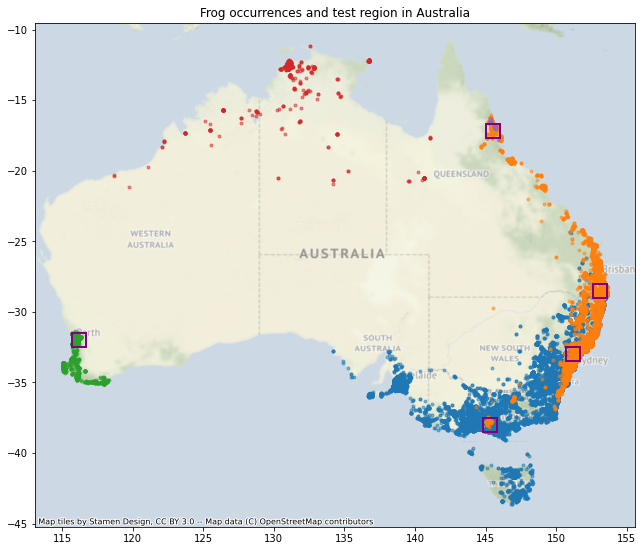

In [81]:
fig = plt.figure(figsize=(20, 7))
ax  = fig.add_axes([0,0,1,1])
ps(fig, ax, all_au_df, 'Australia')

The chart above shows 5 regions of interest in the test set


In [82]:
X_submit = test_file.drop(columns= ['id','decimalLongitude','decimalLatitude','ppt_mean','swe_mean','vap_mean'])
X_submit

,aet_mean,def_mean,pdsi_mean,pet_mean,q_mean,soil_mean,srad_mean,tmax_mean,tmin_mean,vpd_mean,ws_mean
0,57.433333,56.316667,-3.163333,113.700000,3.066667,47.800000,178.016667,20.735002,10.630002,0.723333,5.083333
1,44.866667,73.483333,-2.696666,118.250000,2.416667,12.716667,177.750000,20.991668,10.638335,0.740667,5.421667
2,63.016667,41.766667,-3.690000,104.833333,5.116667,88.783333,177.750000,19.890002,9.645002,0.645000,4.710000
3,45.883333,65.133333,-2.683333,110.950000,2.450000,22.400000,180.083333,20.333334,9.463335,0.716500,4.626667
4,66.900000,32.416667,-3.323333,99.333333,13.483333,103.166667,175.700000,19.018335,9.733335,0.547833,5.340000
...,...,...,...,...,...,...,...,...,...,...,...
4046,48.100000,82.850000,-1.428333,130.883333,17.166667,54.750000,232.966667,23.128335,10.750001,0.978167,3.803333
4047,48.666667,89.433333,-2.831666,138.016667,7.950000,58.483333,233.850000,23.966668,12.865001,0.931833,5.156667
4048,48.516667,90.933333,-2.650000,139.350000,7.500000,63.200000,234.300000,24.053335,13.050001,0.972833,4.856667
4049,43.650000,88.716667,-1.095000,132.350000,14.183333,41.166667,233.100000,23.573335,10.651668,1.028167,3.588333


Dealing with None value using interpolation method

In [83]:
X_submit = X_submit.interpolate(method = 'quadratic')

Normalise the dataset that prepared for ANN model

In [84]:
X_submit =stats.zscore(X_submit)
X_submit

,aet_mean,def_mean,pdsi_mean,pet_mean,q_mean,soil_mean,srad_mean,tmax_mean,tmin_mean,vpd_mean,ws_mean
0,-0.475439,0.168300,-1.153360,-0.405949,-0.553804,-0.500716,-1.092385,-0.968589,-0.720910,-0.389428,1.077217
1,-1.211332,0.989603,-0.466487,-0.005586,-0.601778,-1.168026,-1.105948,-0.859302,-0.717100,-0.259475,1.499496
2,-0.148484,-0.527814,-1.928546,-1.186145,-0.402500,0.278816,-1.105948,-1.328386,-1.171245,-0.976713,0.611254
3,-1.151797,0.590115,-0.446862,-0.647927,-0.599318,-0.983842,-0.987272,-1.139617,-1.254302,-0.440659,0.507245
4,0.078921,-0.975145,-1.388860,-1.670101,0.215017,0.552397,-1.210214,-1.699537,-1.130860,-1.705197,1.397566
...,...,...,...,...,...,...,...,...,...,...,...
4046,-1.021991,1.437732,1.400335,1.106046,0.486872,-0.368522,1.702447,0.050481,-0.666047,1.521124,-0.520370
4047,-0.988807,1.752698,-0.665190,1.733723,-0.193380,-0.297512,1.747375,0.407439,0.300916,1.173751,1.168745
4048,-0.997591,1.824462,-0.397800,1.851045,-0.226593,-0.207797,1.770262,0.444341,0.385497,1.481139,0.794311
4049,-1.282579,1.718410,1.890959,1.235101,0.266682,-0.626887,1.709229,0.239959,-0.711004,1.895988,-0.788714


Now, we predict the test set!


In [88]:
test_file['occurrenceStatus'] = model.predict(X_submit)
test_file['occurrenceStatus'] = np.where(test_file['occurrenceStatus']>=0.5,1,0)
print(test_file['occurrenceStatus'].value_counts())

test_file[['id','decimalLatitude','decimalLongitude','occurrenceStatus']].to_csv('sub.csv')

0    2553
1    1498
Name: occurrenceStatus, dtype: int64


We are excited to improve F1 score from **0.51** to **0.73**, finalized at dense rank **5th** among over **1000 participant teams**. Feel free to use our model for your future SDM research

## Thank you my team and Prof Aditya for interesting lectures!!!